In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import vgg19

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class BSD100Dataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.transform = transform
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_images = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_image = Image.open(os.path.join(self.hr_dir, self.hr_images[idx]))
        lr_image = Image.open(os.path.join(self.lr_dir, self.lr_images[idx]))

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return lr_image, hr_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),
])

# Initialize dataset and dataloader
hr_dir = 'data/bsd100/bicubic_2x/train/HR'
lr_dir = 'data/bsd100/bicubic_2x/train/LR'
dataset = BSD100Dataset(hr_dir, lr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


val_hr_dir = 'data/bsd100/bicubic_2x/val/HR'
val_lr_dir = 'data/bsd100/bicubic_2x/val/LR'
val_dataset = BSD100Dataset(val_hr_dir, val_lr_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_features, num_features // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_features // reduction, num_features, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class RCAB(nn.Module):
    def __init__(self, num_features, reduction):
        super(RCAB, self).__init__()
        self.conv1 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.ca = ChannelAttention(num_features, reduction)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        res = self.ca(res)
        return res + x

class RRDB(nn.Module):
    def __init__(self, num_features, num_grow_channels, reduction):
        super(RRDB, self).__init__()
        self.rcab1 = RCAB(num_features, reduction)
        self.rcab2 = RCAB(num_features, reduction)
        self.rcab3 = RCAB(num_features, reduction)
        self.conv = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.rcab1(x)
        out = self.rcab2(out)
        out = self.rcab3(out)
        out = self.conv(out)
        return out * 0.2 + x

class EASRNGenerator(nn.Module):
    def __init__(self, in_channels, out_channels, num_features, num_blocks, reduction=16, scale_factor=4):
        super(EASRNGenerator, self).__init__()
        self.conv_first = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)
        self.body = nn.Sequential(*[RRDB(num_features, num_features // 2, reduction) for _ in range(num_blocks)])
        self.conv_body = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        
        # Upsampling layers
        self.upconv1 = nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1)
        self.upconv2 = nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        
        self.conv_hr = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.conv_last = nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        feat = self.conv_first(x)
        body_feat = self.body(feat)
        body_feat = self.conv_body(body_feat)
        feat = feat + body_feat
        
        feat = self.lrelu(self.pixel_shuffle(self.upconv1(feat)))
        feat = self.lrelu(self.pixel_shuffle(self.upconv2(feat)))
        
        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

class EASRNDiscriminator(nn.Module):
    def __init__(self, input_shape):
        super(EASRNDiscriminator, self).__init__()
        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = EASRNGenerator(3, 3, 64, 23, reduction=16, scale_factor=4).to(device)
discriminator = EASRNDiscriminator((3, 256, 256)).to(device)

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:35]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()

    def forward(self, x, y):
        vgg_x = self.loss_network(x)
        vgg_y = self.loss_network(y)
        return self.mse_loss(vgg_x, vgg_y)

# Print model summary
print(generator)
print(discriminator)

In [ ]:
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.9, 0.999))
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=50, gamma=0.5)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.L1Loss()

c:\Users\AIML\anaconda3\envs\chandra\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AIML\anaconda3\envs\chandra\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_easrn(generator, discriminator, dataloader, val_dataloader, num_epochs, device):
    # Loss functions
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_content = nn.L1Loss()
    criterion_vgg = VGGLoss().to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=num_epochs, eta_min=1e-7)
    scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=num_epochs, eta_min=1e-7)

    # Gradient scaler for mixed precision training
    scaler_G = GradScaler()
    scaler_D = GradScaler()

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for lr_imgs, hr_imgs in pbar:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # Ensure hr_imgs have the correct dimensions
            b, c, h, w = lr_imgs.shape
            hr_imgs = nn.functional.interpolate(hr_imgs, size=(h * 4, w * 4), mode='bicubic', align_corners=False)

            # Train Discriminator
            optimizer_D.zero_grad()
            
            with autocast():
                sr_imgs = generator(lr_imgs)
                real_pred = discriminator(hr_imgs)
                fake_pred = discriminator(sr_imgs.detach())
                
                loss_real = criterion_GAN(real_pred, torch.ones_like(real_pred))
                loss_fake = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))
                loss_D = (loss_real + loss_fake) / 2

            scaler_D.scale(loss_D).backward()
            scaler_D.step(optimizer_D)
            scaler_D.update()

            # Train Generator
            optimizer_G.zero_grad()
            
            with autocast():
                sr_imgs = generator(lr_imgs)
                fake_pred = discriminator(sr_imgs)
                
                loss_GAN = criterion_GAN(fake_pred, torch.ones_like(fake_pred))
                loss_content = criterion_content(sr_imgs, hr_imgs)
                loss_vgg = criterion_vgg(sr_imgs, hr_imgs)
                
                loss_G = loss_content + 0.001 * loss_GAN + 0.006 * loss_vgg

            scaler_G.scale(loss_G).backward()
            scaler_G.step(optimizer_G)
            scaler_G.update()

            pbar.set_postfix({'D_loss': loss_D.item(), 'G_loss': loss_G.item()})

        scheduler_G.step()
        scheduler_D.step()

        # Validation
        generator.eval()
        val_psnr = []
        with torch.no_grad():
            for lr_imgs, hr_imgs in val_dataloader:
                lr_imgs = lr_imgs.to(device)
                hr_imgs = hr_imgs.to(device)
                b, c, h, w = lr_imgs.shape
                hr_imgs = nn.functional.interpolate(hr_imgs, size=(h * 4, w * 4), mode='bicubic', align_corners=False)
                
                sr_imgs = generator(lr_imgs)
                
                # Calculate PSNR
                mse = nn.functional.mse_loss(sr_imgs, hr_imgs)
                psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
                val_psnr.append(psnr.item())

        avg_psnr = np.mean(val_psnr)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation PSNR: {avg_psnr:.2f}")

        # Save model
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(), f'easrn_generator_epoch_{epoch+1}.pth')
            torch.save(discriminator.state_dict(), f'easrn_discriminator_epoch_{epoch+1}.pth')

    print("Training completed!")

C:\Users\AIML\AppData\Local\Temp\ipykernel_25592\1553804619.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('D:/Chandra/ImageSuperRe

Epoch [1/100], Step [1/5], D_loss: 0.0008, G_loss: 0.0158
Epoch [2/100], Step [1/5], D_loss: 0.0216, G_loss: 0.0915
Epoch [3/100], Step [1/5], D_loss: 0.0132, G_loss: 0.0426
Epoch [4/100], Step [1/5], D_loss: 0.0103, G_loss: 0.0349
Epoch [5/100], Step [1/5], D_loss: 0.0074, G_loss: 0.0282
Epoch [6/100], Step [1/5], D_loss: 0.0045, G_loss: 0.0234
Epoch [7/100], Step [1/5], D_loss: 0.0037, G_loss: 0.0211
Epoch [8/100], Step [1/5], D_loss: 0.0029, G_loss: 0.0189
Epoch [9/100], Step [1/5], D_loss: 0.0024, G_loss: 0.0185
Epoch [10/100], Step [1/5], D_loss: 0.0019, G_loss: 0.0180
Epoch [11/100], Step [1/5], D_loss: 0.0016, G_loss: 0.0186
Epoch [12/100], Step [1/5], D_loss: 0.0013, G_loss: 0.0180
Epoch [13/100], Step [1/5], D_loss: 0.0015, G_loss: 0.0171
Epoch [14/100], Step [1/5], D_loss: 0.0012, G_loss: 0.0186
Epoch [15/100], Step [1/5], D_loss: 0.0011, G_loss: 0.0186
Epoch [16/100], Step [1/5], D_loss: 0.0011, G_loss: 0.0187
Epoch [17/100], Step [1/5], D_loss: 0.0011, G_loss: 0.0169
Epoch 

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

hr_dir = 'data/bsd100/bicubic_2x/train/HR'
lr_dir = 'data/bsd100/bicubic_2x/train/LR'
dataset = BSD100Dataset(hr_dir, lr_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

val_hr_dir = 'data/bsd100/bicubic_2x/val/HR'
val_lr_dir = 'data/bsd100/bicubic_2x/val/LR'
val_dataset = BSD100Dataset(val_hr_dir, val_lr_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# Set up model and training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = EASRNGenerator(3, 3, 64, 23, reduction=16, scale_factor=4).to(device)
discriminator = EASRNDiscriminator((3, 256, 256)).to(device)

# Train the model
train_easrn(generator, discriminator, dataloader, val_dataloader, num_epochs=100, device=device)

Average PSNR: 37.18
Average SSIM: 0.9832


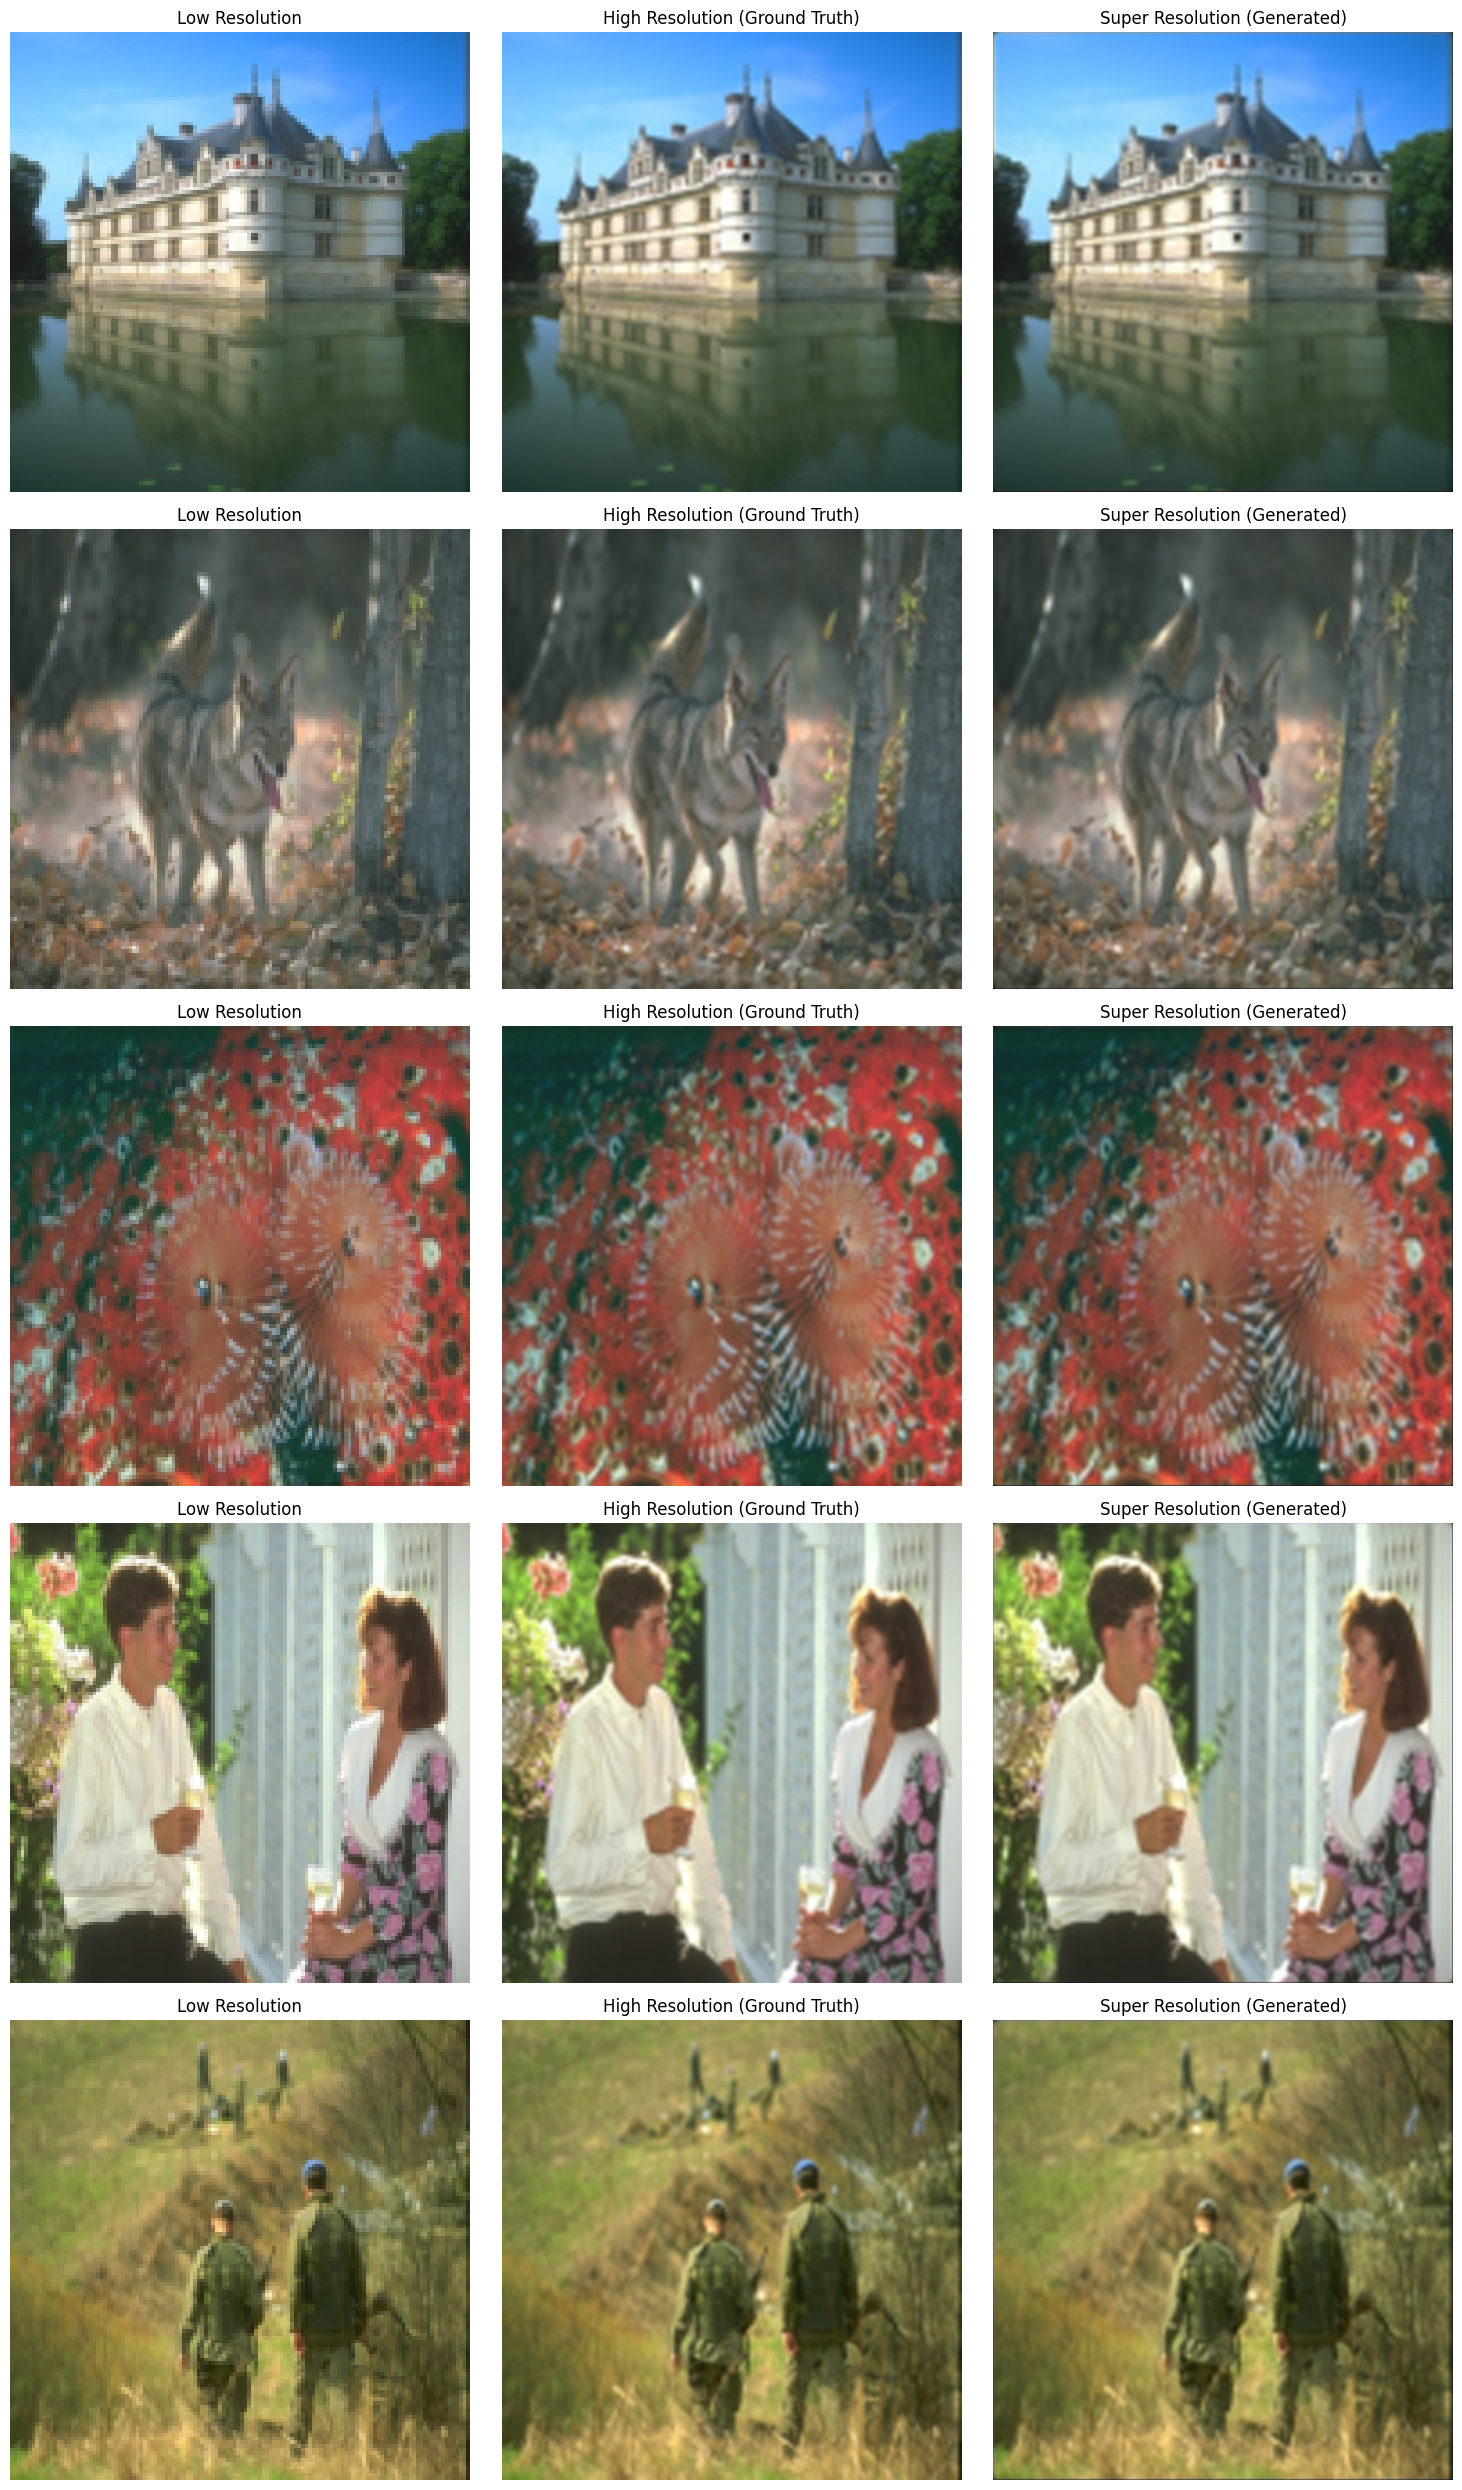

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

def evaluate_model(model, dataloader, device):
    model.eval()
    psnr_list = []
    ssim_list = []
    samples = []

    with torch.no_grad():
        for i, (lr_images, hr_images) in enumerate(dataloader):
            lr_images = lr_images.to(device)
            hr_images = hr_images.to(device)

            # Ensure hr_images have the correct dimensions
            b, c, h, w = lr_images.shape
            hr_images = torch.nn.functional.interpolate(hr_images, size=(h * 4, w * 4), mode='bicubic', align_corners=False)

            # Model prediction
            sr_images = model(lr_images)

            for j in range(sr_images.size(0)):  # Iterate over batch
                # Convert to numpy for evaluation
                sr_image_np = sr_images[j].cpu().numpy().transpose(1, 2, 0)
                hr_image_np = hr_images[j].cpu().numpy().transpose(1, 2, 0)
                lr_image_np = lr_images[j].cpu().numpy().transpose(1, 2, 0)

                # Ensure the images are in the correct range [0, 1]
                sr_image_np = np.clip(sr_image_np, 0, 1)
                hr_image_np = np.clip(hr_image_np, 0, 1)
                lr_image_np = np.clip(lr_image_np, 0, 1)

                # Calculate an appropriate win_size
                win_size = min(hr_image_np.shape[0], hr_image_np.shape[1], 7)
                if win_size % 2 == 0:
                    win_size -= 1

                # Calculate PSNR and SSIM
                psnr_value = psnr(hr_image_np, sr_image_np, data_range=1.0)
                ssim_value = ssim(hr_image_np, sr_image_np, data_range=1.0, channel_axis=2, win_size=win_size)

                psnr_list.append(psnr_value)
                ssim_list.append(ssim_value)

                # Store the first few samples for visualization
                if len(samples) < 5:
                    samples.append((lr_image_np, hr_image_np, sr_image_np))

    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    print(f'Average PSNR: {avg_psnr:.2f}')
    print(f'Average SSIM: {avg_ssim:.4f}')

    return samples

# Visualization function
def visualize_samples(samples):
    fig, axes = plt.subplots(len(samples), 3, figsize=(15, 5*len(samples)))
    
    for i, (lr, hr, sr) in enumerate(samples):
        axes[i, 0].imshow(lr)
        axes[i, 0].set_title('Low Resolution')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(hr)
        axes[i, 1].set_title('High Resolution (Ground Truth)')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sr)
        axes[i, 2].set_title('Super Resolution (Generated)')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Evaluate the model on validation set
samples = evaluate_model(generator, val_dataloader, device)

# Visualize the results
visualize_samples(samples)